# Gradient Descent Methods

This notebook explores the different types of Gradient Descent algorithms:
1. **Batch Gradient Descent** - Uses the entire training set
2. **Stochastic Gradient Descent (SGD)** - Uses one instance at a time
3. **Mini-batch Gradient Descent** - Uses small random batches

We'll visualize how each method converges to the optimal solution and compare their performance.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib
plt.rcParams['figure.figsize'] = (12, 4)
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Understanding the Problem

Let's create a simple linear regression problem to demonstrate gradient descent methods.

**Goal:** Find parameters θ that minimize the Mean Squared Error (MSE):

$$MSE(\theta) = \frac{1}{m}\sum_{i=1}^{m}(\theta^T \cdot x^{(i)} - y^{(i)})^2$$

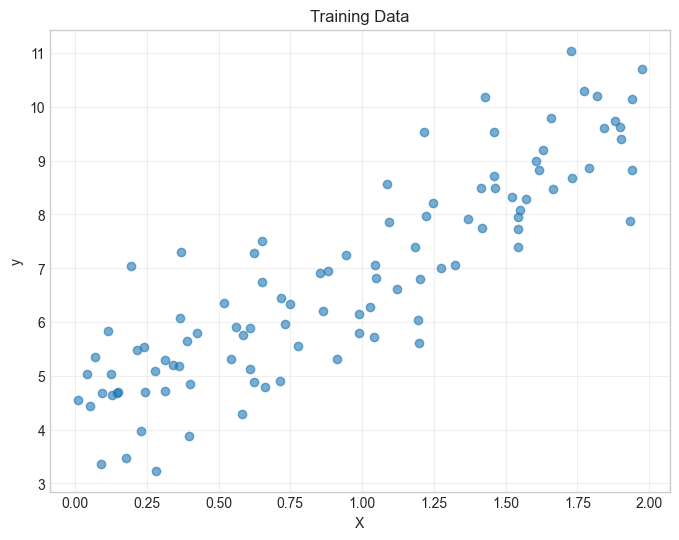

Dataset shape: (100, 1)
Target shape: (100, 1)


In [2]:
# Generate synthetic data
m = 100  # number of instances
X = 2 * np.random.rand(m, 1)
y = 4 + 3 * X + np.random.randn(m, 1)

# Add bias term (x0 = 1) to X
X_b = np.c_[np.ones((m, 1)), X]  # add x0 = 1 to each instance

# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(X, y, alpha=0.6)
plt.xlabel('X')
plt.ylabel('y')
plt.title('Training Data')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Dataset shape: {X.shape}")
print(f"Target shape: {y.shape}")

## 2. Batch Gradient Descent

**Key Concept:** Uses the **entire training set** to compute gradients at each step.

### Algorithm:
$$\theta^{(next\_step)} = \theta - \eta \nabla_{\theta} MSE(\theta)$$

Where the gradient is:
$$\nabla_{\theta} MSE(\theta) = \frac{2}{m}X^T(X\theta - y)$$

**Advantages:**
- Stable convergence
- Guaranteed to converge to global minimum (for convex functions)

**Disadvantages:**
- Very slow on large datasets
- Requires entire dataset in memory

In [3]:
def batch_gradient_descent(X, y, learning_rate=0.1, n_iterations=1000, tolerance=1e-6):
    """
    Batch Gradient Descent implementation
    """
    m = len(X)
    theta = np.random.randn(X.shape[1], 1)  # Random initialization
    
    theta_history = [theta.copy()]
    cost_history = []
    
    for iteration in range(n_iterations):
        # Compute predictions
        predictions = X.dot(theta)
        
        # Compute cost (MSE)
        cost = (1/m) * np.sum((predictions - y)**2)
        cost_history.append(cost)
        
        # Compute gradients using ALL training examples
        gradients = (2/m) * X.T.dot(predictions - y)
        
        # Update parameters
        theta = theta - learning_rate * gradients
        theta_history.append(theta.copy())
        
        # Check convergence
        if len(cost_history) > 1 and abs(cost_history[-1] - cost_history[-2]) < tolerance:
            print(f"Converged at iteration {iteration}")
            break
    
    return theta, np.array(theta_history), np.array(cost_history)

# Run Batch Gradient Descent
print("Running Batch Gradient Descent...")
theta_bgd, theta_history_bgd, cost_history_bgd = batch_gradient_descent(
    X_b, y, learning_rate=0.1, n_iterations=1000
)

print(f"\nFinal parameters: θ0 = {theta_bgd[0][0]:.4f}, θ1 = {theta_bgd[1][0]:.4f}")
print(f"Number of iterations: {len(cost_history_bgd)}")
print(f"Final cost: {cost_history_bgd[-1]:.4f}")

Running Batch Gradient Descent...
Converged at iteration 161

Final parameters: θ0 = 4.2087, θ1 = 2.7757
Number of iterations: 162
Final cost: 0.8066


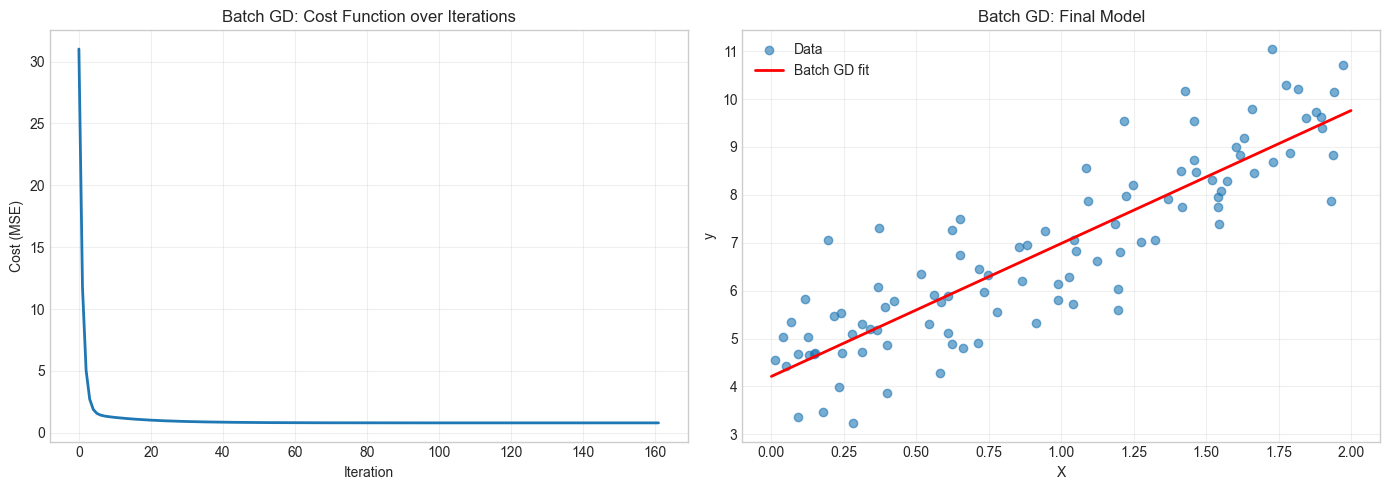

In [4]:
# Visualize Batch GD convergence
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot cost vs iterations
axes[0].plot(cost_history_bgd, linewidth=2)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Cost (MSE)')
axes[0].set_title('Batch GD: Cost Function over Iterations')
axes[0].grid(True, alpha=0.3)

# Plot the final fit
axes[1].scatter(X, y, alpha=0.6, label='Data')
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_bgd)
axes[1].plot(X_new, y_predict, "r-", linewidth=2, label='Batch GD fit')
axes[1].set_xlabel('X')
axes[1].set_ylabel('y')
axes[1].set_title('Batch GD: Final Model')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Stochastic Gradient Descent (SGD)

**Key Concept:** Uses **one random instance** at a time to compute gradients.

### Algorithm:
For each epoch:
1. Shuffle the training set
2. For each instance:
   - Pick a random instance
   - Compute gradient based on that instance only
   - Update parameters

$$\theta^{(next\_step)} = \theta - \eta \nabla_{\theta} MSE(\theta; x^{(i)}, y^{(i)})$$

**Advantages:**
- Much faster (can start making progress immediately)
- Can escape local minima (due to randomness)
- Can handle very large datasets

**Disadvantages:**
- Irregular convergence (lots of bouncing around)
- Never settles at the minimum (keeps bouncing)
- Need learning rate schedule

In [5]:
def stochastic_gradient_descent(X, y, n_epochs=50, learning_rate_schedule=None):
    """
    Stochastic Gradient Descent implementation
    """
    m = len(X)
    theta = np.random.randn(X.shape[1], 1)  # Random initialization
    
    theta_history = [theta.copy()]
    cost_history = []
    
    # Default learning rate schedule
    if learning_rate_schedule is None:
        def learning_rate_schedule(t):
            t0, t1 = 5, 50  # learning schedule hyperparameters
            return t0 / (t + t1)
    
    for epoch in range(n_epochs):
        # Shuffle the data at the start of each epoch
        indices = np.random.permutation(m)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        for i in range(m):
            # Pick ONE random instance
            xi = X_shuffled[i:i+1]
            yi = y_shuffled[i:i+1]
            
            # Compute gradients using ONLY this instance
            prediction = xi.dot(theta)
            gradient = 2 * xi.T.dot(prediction - yi)
            
            # Adaptive learning rate
            eta = learning_rate_schedule(epoch * m + i)
            
            # Update parameters
            theta = theta - eta * gradient
            theta_history.append(theta.copy())
        
        # Compute cost for the entire dataset (for visualization)
        predictions = X.dot(theta)
        cost = (1/m) * np.sum((predictions - y)**2)
        cost_history.append(cost)
    
    return theta, np.array(theta_history), np.array(cost_history)

# Run Stochastic Gradient Descent
print("Running Stochastic Gradient Descent...")
theta_sgd, theta_history_sgd, cost_history_sgd = stochastic_gradient_descent(
    X_b, y, n_epochs=50
)

print(f"\nFinal parameters: θ0 = {theta_sgd[0][0]:.4f}, θ1 = {theta_sgd[1][0]:.4f}")
print(f"Number of epochs: 50")
print(f"Final cost: {cost_history_sgd[-1]:.4f}")

Running Stochastic Gradient Descent...

Final parameters: θ0 = 4.2138, θ1 = 2.7696
Number of epochs: 50
Final cost: 0.8066


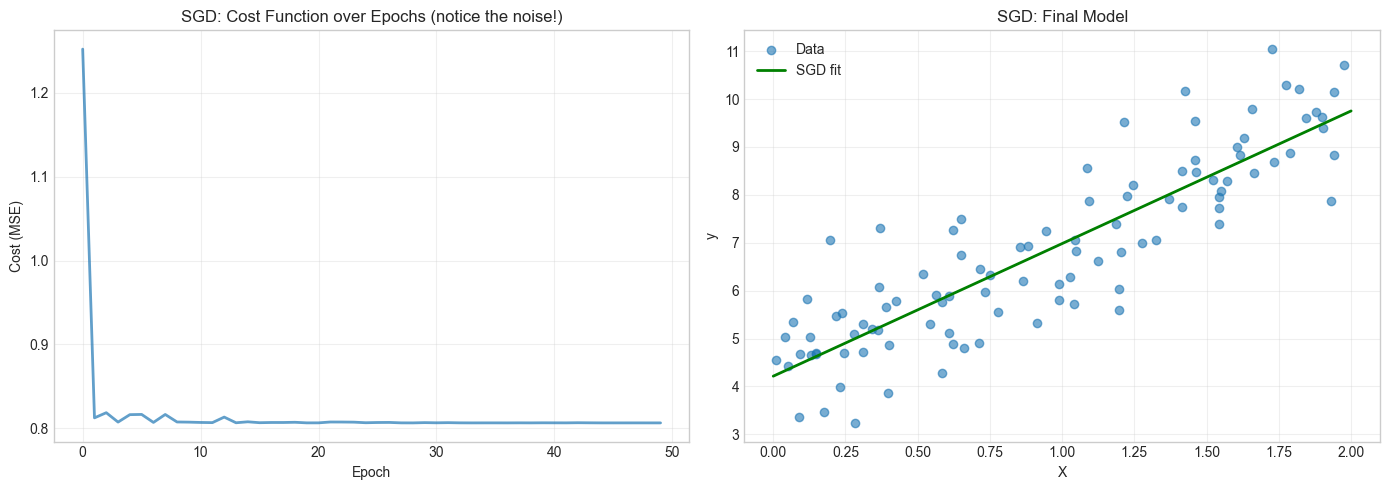

In [6]:
# Visualize SGD convergence
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot cost vs epochs
axes[0].plot(cost_history_sgd, linewidth=2, alpha=0.7)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Cost (MSE)')
axes[0].set_title('SGD: Cost Function over Epochs (notice the noise!)')
axes[0].grid(True, alpha=0.3)

# Plot the final fit
axes[1].scatter(X, y, alpha=0.6, label='Data')
y_predict_sgd = X_new_b.dot(theta_sgd)
axes[1].plot(X_new, y_predict_sgd, "g-", linewidth=2, label='SGD fit')
axes[1].set_xlabel('X')
axes[1].set_ylabel('y')
axes[1].set_title('SGD: Final Model')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Mini-batch Gradient Descent

**Key Concept:** Uses **small random batches** of instances to compute gradients.

### Algorithm:
For each epoch:
1. Shuffle the training set
2. Split into mini-batches
3. For each mini-batch:
   - Compute gradient based on that mini-batch
   - Update parameters

**Advantages:**
- More stable than SGD (less noisy gradients)
- Can leverage hardware optimization (GPU/matrix operations)
- Good balance between speed and stability

**Disadvantages:**
- One more hyperparameter (batch size) to tune
- Still has some noise (but less than SGD)

In [7]:
def minibatch_gradient_descent(X, y, n_epochs=50, batch_size=20, learning_rate_schedule=None):
    """
    Mini-batch Gradient Descent implementation
    """
    m = len(X)
    theta = np.random.randn(X.shape[1], 1)  # Random initialization
    
    theta_history = [theta.copy()]
    cost_history = []
    
    # Default learning rate schedule
    if learning_rate_schedule is None:
        def learning_rate_schedule(t):
            t0, t1 = 200, 1000
            return t0 / (t + t1)
    
    n_batches = m // batch_size
    
    for epoch in range(n_epochs):
        # Shuffle the data
        indices = np.random.permutation(m)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        for batch_idx in range(n_batches):
            # Get mini-batch
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_size
            X_batch = X_shuffled[start_idx:end_idx]
            y_batch = y_shuffled[start_idx:end_idx]
            
            # Compute gradients using the mini-batch
            predictions = X_batch.dot(theta)
            gradients = (2/batch_size) * X_batch.T.dot(predictions - y_batch)
            
            # Adaptive learning rate
            eta = learning_rate_schedule(epoch * n_batches + batch_idx)
            
            # Update parameters
            theta = theta - eta * gradients
            theta_history.append(theta.copy())
        
        # Compute cost for the entire dataset (for visualization)
        predictions = X.dot(theta)
        cost = (1/m) * np.sum((predictions - y)**2)
        cost_history.append(cost)
    
    return theta, np.array(theta_history), np.array(cost_history)

# Run Mini-batch Gradient Descent
print("Running Mini-batch Gradient Descent...")
theta_mbgd, theta_history_mbgd, cost_history_mbgd = minibatch_gradient_descent(
    X_b, y, n_epochs=50, batch_size=20
)

print(f"\nFinal parameters: θ0 = {theta_mbgd[0][0]:.4f}, θ1 = {theta_mbgd[1][0]:.4f}")
print(f"Number of epochs: 50")
print(f"Batch size: 20")
print(f"Final cost: {cost_history_mbgd[-1]:.4f}")

Running Mini-batch Gradient Descent...

Final parameters: θ0 = 4.1891, θ1 = 2.7498
Number of epochs: 50
Batch size: 20
Final cost: 0.8088


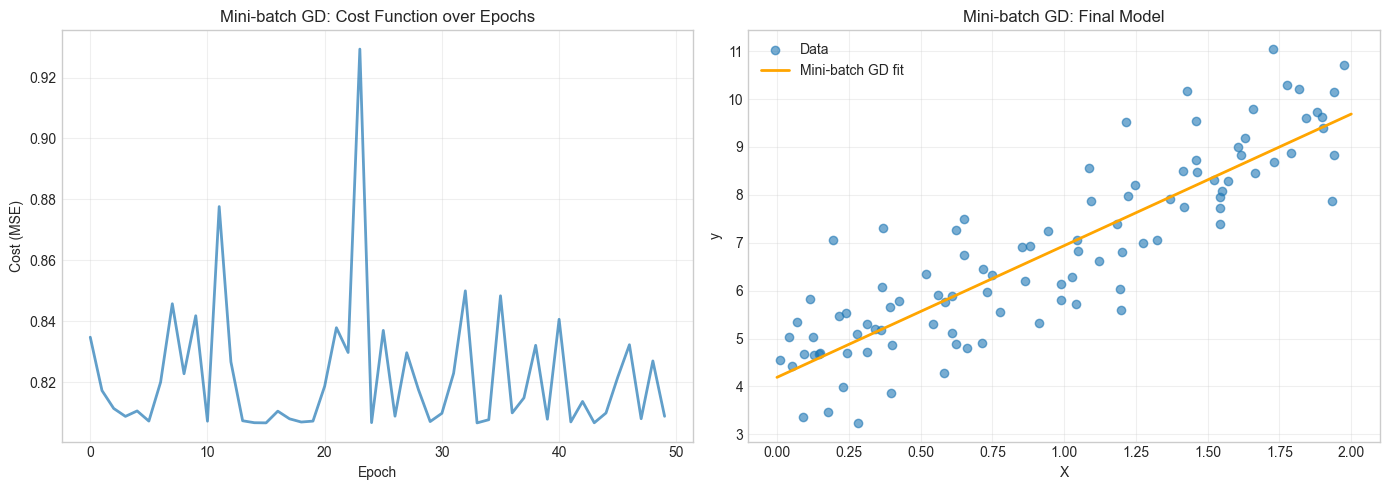

In [8]:
# Visualize Mini-batch GD convergence
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot cost vs epochs
axes[0].plot(cost_history_mbgd, linewidth=2, alpha=0.7)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Cost (MSE)')
axes[0].set_title('Mini-batch GD: Cost Function over Epochs')
axes[0].grid(True, alpha=0.3)

# Plot the final fit
axes[1].scatter(X, y, alpha=0.6, label='Data')
y_predict_mbgd = X_new_b.dot(theta_mbgd)
axes[1].plot(X_new, y_predict_mbgd, "orange", linewidth=2, label='Mini-batch GD fit')
axes[1].set_xlabel('X')
axes[1].set_ylabel('y')
axes[1].set_title('Mini-batch GD: Final Model')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Comparison of All Three Methods

Let's compare all three gradient descent methods side by side.

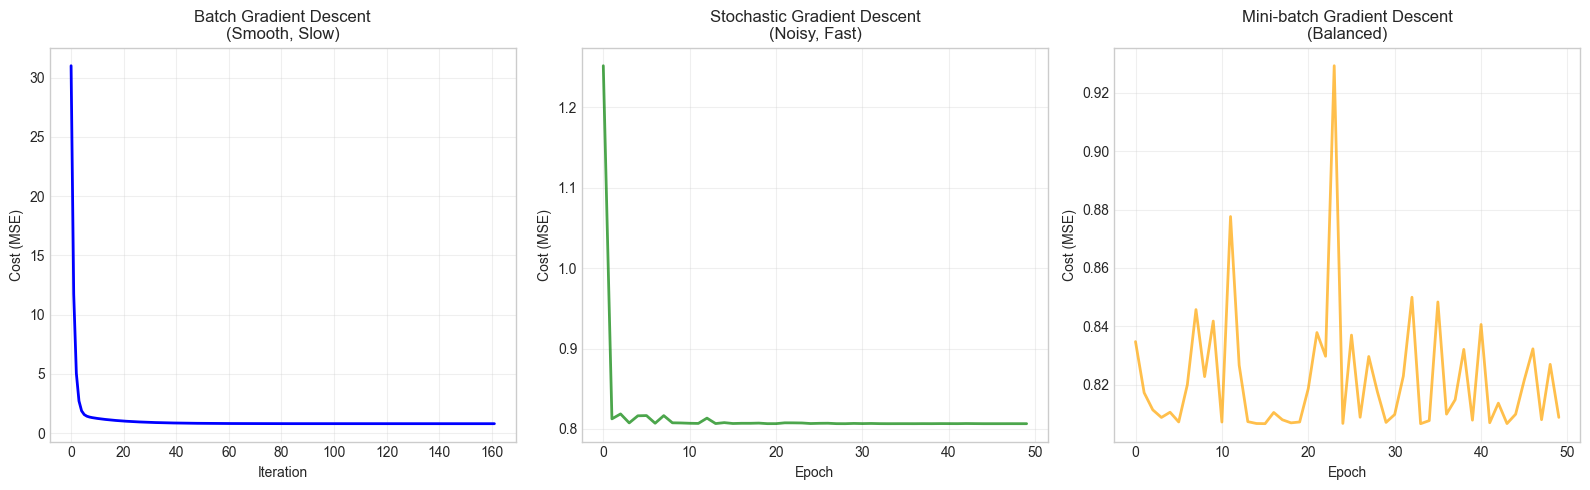

In [9]:
# Compare convergence of all three methods
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Batch GD
axes[0].plot(cost_history_bgd, 'b-', linewidth=2)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Cost (MSE)')
axes[0].set_title('Batch Gradient Descent\n(Smooth, Slow)')
axes[0].grid(True, alpha=0.3)

# Stochastic GD
axes[1].plot(cost_history_sgd, 'g-', linewidth=2, alpha=0.7)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Cost (MSE)')
axes[1].set_title('Stochastic Gradient Descent\n(Noisy, Fast)')
axes[1].grid(True, alpha=0.3)

# Mini-batch GD
axes[2].plot(cost_history_mbgd, 'orange', linewidth=2, alpha=0.7)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Cost (MSE)')
axes[2].set_title('Mini-batch Gradient Descent\n(Balanced)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

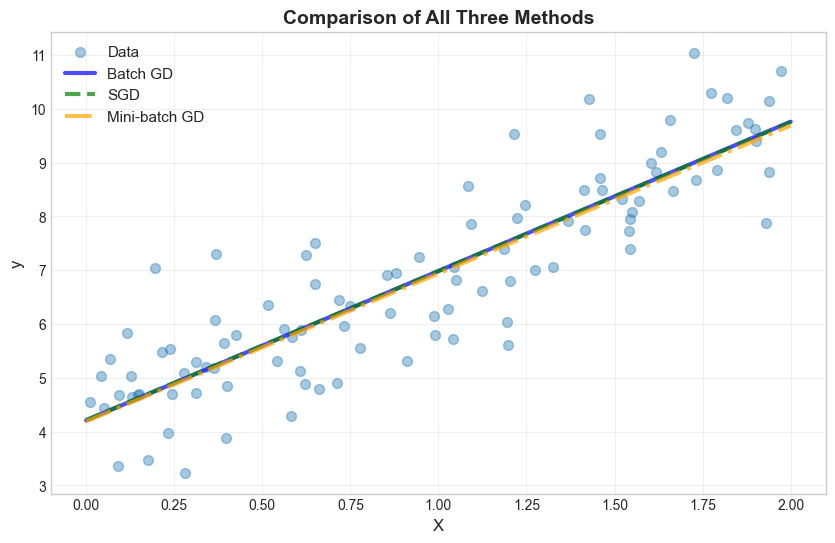


FINAL PARAMETERS COMPARISON:
Batch GD:       θ0 =  4.2087, θ1 =  2.7757
Stochastic GD:  θ0 =  4.2138, θ1 =  2.7696
Mini-batch GD:  θ0 =  4.1891, θ1 =  2.7498


In [10]:
# Compare all three fits on the same plot
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.4, label='Data', s=50)

# Batch GD
y_predict_bgd = X_new_b.dot(theta_bgd)
plt.plot(X_new, y_predict_bgd, "b-", linewidth=3, label='Batch GD', alpha=0.7)

# Stochastic GD
y_predict_sgd = X_new_b.dot(theta_sgd)
plt.plot(X_new, y_predict_sgd, "g--", linewidth=3, label='SGD', alpha=0.7)

# Mini-batch GD
y_predict_mbgd = X_new_b.dot(theta_mbgd)
plt.plot(X_new, y_predict_mbgd, "orange", linewidth=3, label='Mini-batch GD', 
         linestyle='-.', alpha=0.7)

plt.xlabel('X', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Comparison of All Three Methods', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

# Print final parameters
print("\n" + "="*60)
print("FINAL PARAMETERS COMPARISON:")
print("="*60)
print(f"Batch GD:       θ0 = {theta_bgd[0][0]:7.4f}, θ1 = {theta_bgd[1][0]:7.4f}")
print(f"Stochastic GD:  θ0 = {theta_sgd[0][0]:7.4f}, θ1 = {theta_sgd[1][0]:7.4f}")
print(f"Mini-batch GD:  θ0 = {theta_mbgd[0][0]:7.4f}, θ1 = {theta_mbgd[1][0]:7.4f}")
print("="*60)

## 6. Visualizing the Parameter Space

Let's visualize how each method navigates through the parameter space (θ0, θ1) to find the minimum.

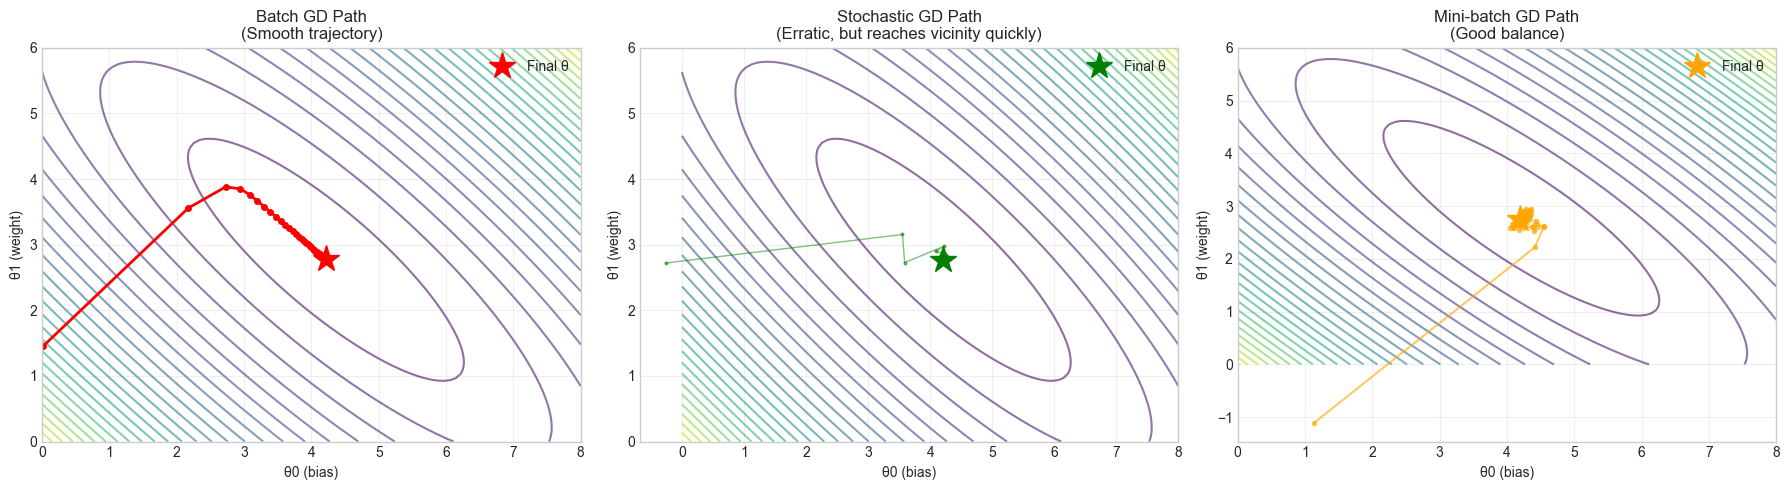

In [11]:
# Create a grid for contour plot
theta0_vals = np.linspace(0, 8, 100)
theta1_vals = np.linspace(0, 6, 100)
theta0_grid, theta1_grid = np.meshgrid(theta0_vals, theta1_vals)

# Compute cost for each point in the grid
cost_grid = np.zeros_like(theta0_grid)
for i in range(theta0_grid.shape[0]):
    for j in range(theta0_grid.shape[1]):
        theta_test = np.array([[theta0_grid[i, j]], [theta1_grid[i, j]]])
        predictions = X_b.dot(theta_test)
        cost_grid[i, j] = (1/m) * np.sum((predictions - y)**2)

# Plot the parameter space and paths
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Batch GD path
axes[0].contour(theta0_grid, theta1_grid, cost_grid, levels=30, alpha=0.6, cmap='viridis')
path_bgd = theta_history_bgd[::max(1, len(theta_history_bgd)//50)]  # Sample points
axes[0].plot(path_bgd[:, 0], path_bgd[:, 1], 'r.-', linewidth=2, markersize=8)
axes[0].plot(theta_bgd[0], theta_bgd[1], 'r*', markersize=20, label='Final θ')
axes[0].set_xlabel('θ0 (bias)')
axes[0].set_ylabel('θ1 (weight)')
axes[0].set_title('Batch GD Path\n(Smooth trajectory)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Stochastic GD path
axes[1].contour(theta0_grid, theta1_grid, cost_grid, levels=30, alpha=0.6, cmap='viridis')
path_sgd = theta_history_sgd[::max(1, len(theta_history_sgd)//100)]  # Sample more points
axes[1].plot(path_sgd[:, 0], path_sgd[:, 1], 'g.-', linewidth=1, markersize=4, alpha=0.5)
axes[1].plot(theta_sgd[0], theta_sgd[1], 'g*', markersize=20, label='Final θ')
axes[1].set_xlabel('θ0 (bias)')
axes[1].set_ylabel('θ1 (weight)')
axes[1].set_title('Stochastic GD Path\n(Erratic, but reaches vicinity quickly)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Mini-batch GD path
axes[2].contour(theta0_grid, theta1_grid, cost_grid, levels=30, alpha=0.6, cmap='viridis')
path_mbgd = theta_history_mbgd[::max(1, len(theta_history_mbgd)//100)]  # Sample points
axes[2].plot(path_mbgd[:, 0], path_mbgd[:, 1], '.-', color='orange', linewidth=1.5, 
             markersize=6, alpha=0.6)
axes[2].plot(theta_mbgd[0], theta_mbgd[1], '*', color='orange', markersize=20, label='Final θ')
axes[2].set_xlabel('θ0 (bias)')
axes[2].set_ylabel('θ1 (weight)')
axes[2].set_title('Mini-batch GD Path\n(Good balance)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Learning Rate Schedules

For SGD and Mini-batch GD, using a **learning rate schedule** is crucial for good convergence.

Common schedules:
1. **Step decay**: Reduce learning rate by a factor every few epochs
2. **Exponential decay**: Exponentially decrease learning rate
3. **1/t decay**: $\eta = \frac{t_0}{t + t_1}$
4. **Cosine annealing**: Use cosine function to decrease learning rate

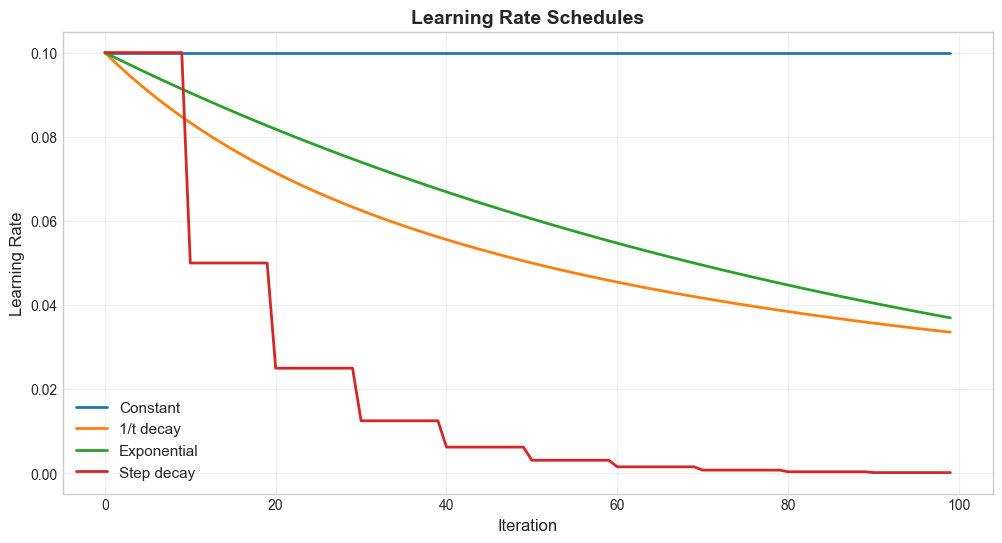

In [12]:
# Compare different learning rate schedules
def constant_schedule(t, eta0=0.1):
    return eta0

def inverse_time_schedule(t, t0=5, t1=50):
    return t0 / (t + t1)

def exponential_schedule(t, eta0=0.1, decay_rate=0.99):
    return eta0 * (decay_rate ** t)

def step_decay_schedule(t, eta0=0.1, drop=0.5, epochs_drop=10):
    return eta0 * (drop ** np.floor(t / epochs_drop))

# Visualize different schedules
t_values = np.arange(0, 100)

plt.figure(figsize=(12, 6))
plt.plot(t_values, [constant_schedule(t) for t in t_values], 
         label='Constant', linewidth=2)
plt.plot(t_values, [inverse_time_schedule(t) for t in t_values], 
         label='1/t decay', linewidth=2)
plt.plot(t_values, [exponential_schedule(t) for t in t_values], 
         label='Exponential', linewidth=2)
plt.plot(t_values, [step_decay_schedule(t) for t in t_values], 
         label='Step decay', linewidth=2)

plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Learning Rate', fontsize=12)
plt.title('Learning Rate Schedules', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

## 8. Using Scikit-Learn's SGDRegressor

Scikit-learn provides an optimized implementation with many useful features.

In [13]:
from sklearn.linear_model import SGDRegressor

# Scale the data (important for SGD!)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create and train SGDRegressor
sgd_reg = SGDRegressor(
    max_iter=1000,
    tol=1e-3,
    penalty=None,  # No regularization
    eta0=0.01,     # Initial learning rate
    learning_rate='invscaling',  # Learning rate schedule
    random_state=42
)

sgd_reg.fit(X_scaled, y.ravel())

print("Scikit-Learn SGDRegressor Results:")
print("="*50)
print(f"Intercept (θ0): {sgd_reg.intercept_[0]:.4f}")
print(f"Coefficient (θ1): {sgd_reg.coef_[0]:.4f}")
print(f"Number of iterations: {sgd_reg.n_iter_}")

Scikit-Learn SGDRegressor Results:
Intercept (θ0): 6.7821
Coefficient (θ1): 1.6290
Number of iterations: 28


## 9. Summary and Key Takeaways

### Comparison Table

| Method | Training Set Usage | Convergence | Speed | Memory | Best Use Case |
|--------|-------------------|-------------|-------|--------|---------------|
| **Batch GD** | All instances | Smooth, stable | Slow | High | Small datasets, need stable convergence |
| **Stochastic GD** | 1 instance at a time | Noisy, irregular | Very fast | Low | Large datasets, online learning |
| **Mini-batch GD** | Small batches | Moderately noisy | Fast | Medium | Most cases, good balance |

### Key Insights:

1. **Batch GD**: 
   - Computes gradients over entire training set
   - Stable but slow on large datasets
   - Guaranteed to converge to global minimum (for convex functions)

2. **Stochastic GD**:
   - Updates parameters for each training instance
   - Much faster, can escape local minima
   - Needs learning rate schedule
   - Never settles at minimum (keeps bouncing)

3. **Mini-batch GD**:
   - Best of both worlds
   - Industry standard for deep learning
   - Typical batch sizes: 32, 64, 128, 256
   - Can leverage GPU optimization

4. **Learning Rate**:
   - Too high: Diverges or bounces around
   - Too low: Takes forever to converge
   - Use learning rate schedules for SGD/Mini-batch

5. **Practical Tips**:
   - Always scale your features before using gradient descent
   - Start with mini-batch GD (batch size ≈ 32-256)
   - Monitor the cost function to check convergence
   - Use early stopping to prevent overfitting

### When to use each method:

- **Small dataset (< 10,000 samples)**: Batch GD is fine
- **Large dataset**: Use Mini-batch GD or SGD
- **Online learning** (streaming data): Use SGD
- **Deep learning**: Almost always Mini-batch GD

## 10. Additional Experiment: Effect of Batch Size

Let's see how different batch sizes affect convergence.

Testing different batch sizes...

Batch size =   1 | Final cost = 0.8198 | θ0 = 4.0644, θ1 = 2.8105
Batch size =   5 | Final cost = 0.9064 | θ0 = 4.3320, θ1 = 2.9598
Batch size =  10 | Final cost = 0.8071 | θ0 = 4.2127, θ1 = 2.7931
Batch size =  20 | Final cost = 0.8096 | θ0 = 4.1863, θ1 = 2.7448
Batch size =  50 | Final cost = 0.8067 | θ0 = 4.2205, θ1 = 2.7748
Batch size = 100 | Final cost = 0.8074 | θ0 = 4.1636, θ1 = 2.8155


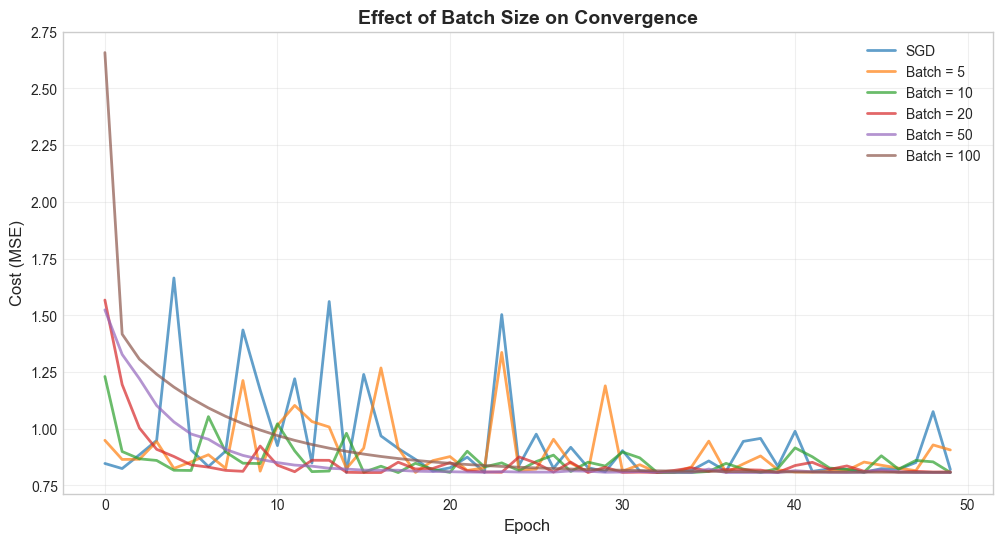

In [14]:
# Test different batch sizes
batch_sizes = [1, 5, 10, 20, 50, 100]  # 1 = SGD, 100 = Batch GD
results = {}

print("Testing different batch sizes...\n")
print("="*70)

for batch_size in batch_sizes:
    theta, _, cost_hist = minibatch_gradient_descent(
        X_b, y, n_epochs=50, batch_size=batch_size
    )
    results[batch_size] = cost_hist
    print(f"Batch size = {batch_size:3d} | Final cost = {cost_hist[-1]:.4f} | "
          f"θ0 = {theta[0][0]:.4f}, θ1 = {theta[1][0]:.4f}")

# Visualize
plt.figure(figsize=(12, 6))
for batch_size in batch_sizes:
    label = 'SGD' if batch_size == 1 else f'Batch = {batch_size}'
    plt.plot(results[batch_size], label=label, linewidth=2, alpha=0.7)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Cost (MSE)', fontsize=12)
plt.title('Effect of Batch Size on Convergence', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

---

## Conclusion

### Mastering Gradient Descent: The Foundation of Modern ML

Gradient descent is not just an optimization algorithm—it's the **backbone of virtually all machine learning training**. Understanding its variants is essential for any ML practitioner.

**The Three Pillars:**

**1. Batch Gradient Descent**
- **Characteristics**: Uses entire dataset per update
- **Pros**: Smooth convergence, deterministic path, guaranteed convergence to global minimum (convex) or good local minimum
- **Cons**: Slow on large datasets, requires full dataset in memory
- **Use Case**: Small datasets, when you need precise convergence, theoretical analysis

**2. Stochastic Gradient Descent (SGD)**
- **Characteristics**: Updates parameters after each single sample
- **Pros**: Very fast updates, can escape shallow local minima, works with streaming data
- **Cons**: Noisy convergence, may oscillate around minimum, requires careful learning rate tuning
- **Use Case**: Online learning, very large datasets, when you want to see quick initial progress

**3. Mini-Batch Gradient Descent**
- **Characteristics**: Updates using small batches (typically 32-512 samples)
- **Pros**: Leverages vectorization, stable convergence, GPU-friendly, balances speed and stability
- **Cons**: Requires batch size tuning, still needs multiple passes through data
- **Use Case**: **Default choice for most applications**, especially deep learning

### Critical Success Factors

**1. Feature Scaling (ESSENTIAL)**
```
✅ Always scale: StandardScaler, MinMaxScaler, or similar
❌ Never skip this step—unscaled features cause severe convergence issues
```

**2. Learning Rate Selection**
```
Too high → Divergence, overshooting
Too low → Extremely slow convergence
Sweet spot → Steady, consistent improvement
```

**3. Convergence Monitoring**
```
Track cost function every epoch
Look for: Steady decrease, plateauing, or signs of divergence
Adjust hyperparameters based on observed behavior
```

### Practical Decision Framework

| Your Situation | Best Choice | Typical Settings |
|----------------|-------------|------------------|
| Dataset < 10K samples | **Batch GD** | Full batch, α=0.01-0.1 |
| Dataset > 1M samples | **Mini-batch GD** | Batch=32-256, α=0.001-0.01 |
| Online/streaming data | **SGD** | Batch=1, adaptive α |
| Deep learning | **Mini-batch GD** + optimizer | Batch=32-512, Adam/SGD |
| Need interpretability | **Batch GD** | Full batch, smaller α |
| Limited memory | **SGD or Mini-batch** | Smaller batches |

### Beyond Basic Gradient Descent

The concepts learned here extend to advanced optimizers:
- **Momentum**: Accelerates convergence, reduces oscillations
- **Adam**: Adaptive learning rates, most popular in deep learning
- **RMSprop**: Handles non-stationary objectives well
- **AdaGrad**: Adapts learning rate per parameter

All these build on the same fundamental principle: **iteratively moving in the direction that reduces the cost function**.

### Final Thoughts

**Key Takeaways:**
1. Gradient descent finds optimal parameters by following the negative gradient
2. The variant you choose depends on dataset size and computational resources
3. Proper hyperparameter tuning (α, batch size) is critical for success
4. Always preprocess your data—feature scaling is non-negotiable
5. Monitor convergence to diagnose and fix training issues

**Remember**: Whether you're training a simple linear regression or a complex neural network with billions of parameters, gradient descent is working behind the scenes. Understanding it deeply gives you the power to debug, optimize, and innovate in any ML project.